# Chuẩn bị dữ liệu

In [86]:
import pyodbc
import pandas as pd
import numpy as np

In [74]:
server_name = 'DESKTOP-TOL1F2F\MSSQLSERVERBI'
database_name = 'AdventureWorksDW2012'

connection = pyodbc.connect('Driver={SQL Server}; Server=' + server_name +
                      '; Database=' + database_name +
                      '; Trusted_Connection=yes;')

In [75]:
df = pd.read_sql_query("SELECT * FROM [dbo].[FactInternetSales];", connection) 

print(df.head())
print(type(df))

   ProductKey  OrderDateKey  DueDateKey  ShipDateKey  CustomerKey  \
0         310      20101229    20110110     20110105        21768   
1         346      20101229    20110110     20110105        28389   
2         346      20101229    20110110     20110105        25863   
3         336      20101229    20110110     20110105        14501   
4         346      20101229    20110110     20110105        11003   

   PromotionKey  CurrencyKey  SalesTerritoryKey SalesOrderNumber  \
0             1           19                  6          SO43697   
1             1           39                  7          SO43698   
2             1          100                  1          SO43699   
3             1          100                  4          SO43700   
4             1            6                  9          SO43701   

   SalesOrderLineNumber  ...  ProductStandardCost  TotalProductCost  \
0                     1  ...            2171.2942         2171.2942   
1                     1  ...      

In [76]:
to_be_removed = ['id', 'ID', 'Key', 'Number', 'CreditCardApprovalCode', 'Comment']
for col in df.columns:
    for r in to_be_removed:
        if r in col:
            df.drop(columns=[col], inplace=True)

print(df.head())

   OrderQuantity  UnitPrice  ExtendedAmount  UnitPriceDiscountPct  \
0              1  3578.2700       3578.2700                   0.0   
1              1  3399.9900       3399.9900                   0.0   
2              1  3399.9900       3399.9900                   0.0   
3              1   699.0982        699.0982                   0.0   
4              1  3399.9900       3399.9900                   0.0   

   DiscountAmount  ProductStandardCost  TotalProductCost  SalesAmount  \
0             0.0            2171.2942         2171.2942    3578.2700   
1             0.0            1912.1544         1912.1544    3399.9900   
2             0.0            1912.1544         1912.1544    3399.9900   
3             0.0             413.1463          413.1463     699.0982   
4             0.0            1912.1544         1912.1544    3399.9900   

     TaxAmt  Freight  OrderDate    DueDate   ShipDate  
0  286.2616  89.4568 2010-12-29 2011-01-10 2011-01-05  
1  271.9992  84.9998 2010-12-29 20

# Thống kê mô tả
1. Thống kê kích thước tập dữ liệu
2. Thống kê các độ đo trung tâm, phân tán
3. Thống kê số lượng dữ liệu missing
4. Loại bỏ các thuộc tính không sử dụng

## 1. Thống kê kích thước tập dữ liệu

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60398 entries, 0 to 60397
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   OrderQuantity         60398 non-null  int64         
 1   UnitPrice             60398 non-null  float64       
 2   ExtendedAmount        60398 non-null  float64       
 3   UnitPriceDiscountPct  60398 non-null  float64       
 4   DiscountAmount        60398 non-null  float64       
 5   ProductStandardCost   60398 non-null  float64       
 6   TotalProductCost      60398 non-null  float64       
 7   SalesAmount           60398 non-null  float64       
 8   TaxAmt                60398 non-null  float64       
 9   Freight               60398 non-null  float64       
 10  OrderDate             60398 non-null  datetime64[ns]
 11  DueDate               60398 non-null  datetime64[ns]
 12  ShipDate              60398 non-null  datetime64[ns]
dtypes: datetime64[ns

## Thống kê các độ đo trung tâm, phân tán

In [78]:
df.describe(include='all', datetime_is_numeric=True)

,OrderQuantity,UnitPrice,ExtendedAmount,UnitPriceDiscountPct,DiscountAmount,ProductStandardCost,TotalProductCost,SalesAmount,TaxAmt,Freight,OrderDate,DueDate,ShipDate
count,60398.0,60398.000000,60398.000000,60398.0,60398.0,60398.000000,60398.000000,60398.000000,60398.000000,60398.000000,60398,60398,60398
mean,1.0,486.086911,486.086911,0.0,0.0,286.065657,286.065657,486.086911,38.886954,12.152217,2013-06-09 12:21:38.903937536,2013-06-21 12:21:38.903937280,2013-06-16 12:21:38.903937280
min,1.0,2.290000,2.290000,0.0,0.0,0.856500,0.856500,2.290000,0.183200,0.057300,2010-12-29 00:00:00,2011-01-10 00:00:00,2011-01-05 00:00:00
25%,1.0,7.950000,7.950000,0.0,0.0,2.973300,2.973300,7.950000,0.636000,0.198800,2013-04-03 00:00:00,2013-04-15 00:00:00,2013-04-10 00:00:00
50%,1.0,29.990000,29.990000,0.0,0.0,11.216300,11.216300,29.990000,2.399200,0.749800,2013-07-14 00:00:00,2013-07-26 00:00:00,2013-07-21 00:00:00
75%,1.0,539.990000,539.990000,0.0,0.0,294.579700,294.579700,539.990000,43.199200,13.499800,2013-10-18 00:00:00,2013-10-30 00:00:00,2013-10-25 00:00:00
max,1.0,3578.270000,3578.270000,0.0,0.0,2171.294200,2171.294200,3578.270000,286.261600,89.456800,2014-01-28 00:00:00,2014-02-09 00:00:00,2014-02-04 00:00:00
std,0.0,928.489892,928.489892,0.0,0.0,552.457641,552.457641,928.489892,74.279193,23.212248,NaN,NaN,NaN


## Thống kê số lượng dữ liệu missing

In [79]:
df.isna().sum()

OrderQuantity           0
UnitPrice               0
ExtendedAmount          0
UnitPriceDiscountPct    0
DiscountAmount          0
ProductStandardCost     0
TotalProductCost        0
SalesAmount             0
TaxAmt                  0
Freight                 0
OrderDate               0
DueDate                 0
ShipDate                0
dtype: int64

# Xử lý dữ liệu
Tính tổng doanh thu theo từng tháng của năm phục vụ cho trực quan hoá dữ liệu theo thời gian.

In [83]:
# Chỉ lấy 2 thuộc tính là OrderDate và SalesAmount
time_series_df = df[['OrderDate', 'SalesAmount']]
# Xử lý OrderDate, tính SalesAmount theo từng tháng của năm

time_series_df = time_series_df.groupby(pd.Grouper(key='OrderDate', freq='M')).sum()

print(time_series_df.tail())

            SalesAmount
OrderDate              
2013-09-30   1447495.69
2013-10-31   1673293.41
2013-11-30   1780920.06
2013-12-31   1874360.29
2014-01-31     45694.72


# Trực quan hoá dữ liệu

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

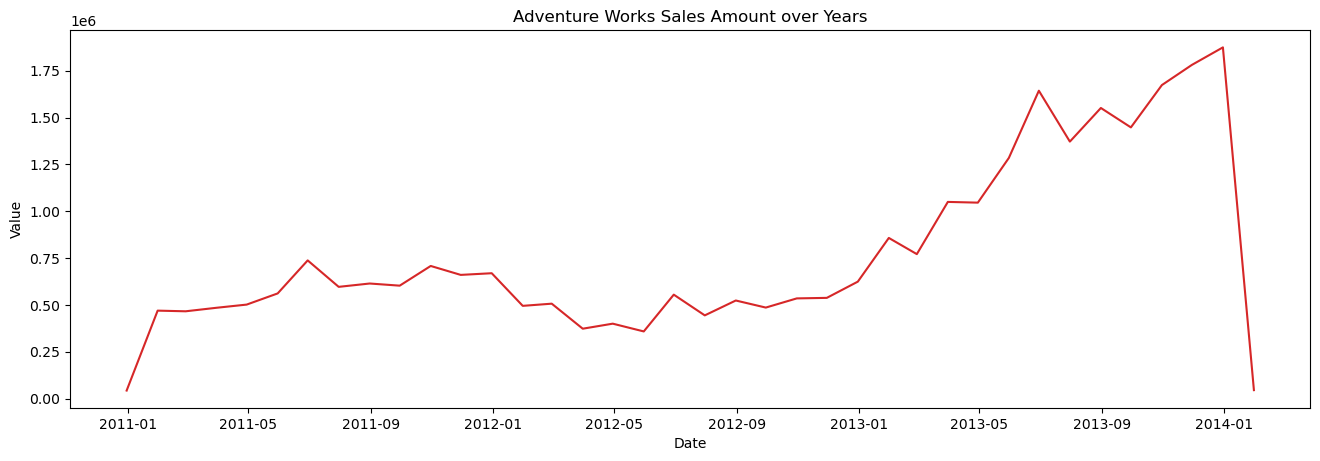

In [84]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(time_series_df, time_series_df.index, time_series_df['SalesAmount'], title='Adventure Works Sales Amount over Years')

Nhận xét:
- Doanh thu giảm ở năm 2012 so với năm 2011 và tăng trưởng mạnh trở lại vào năm 2013

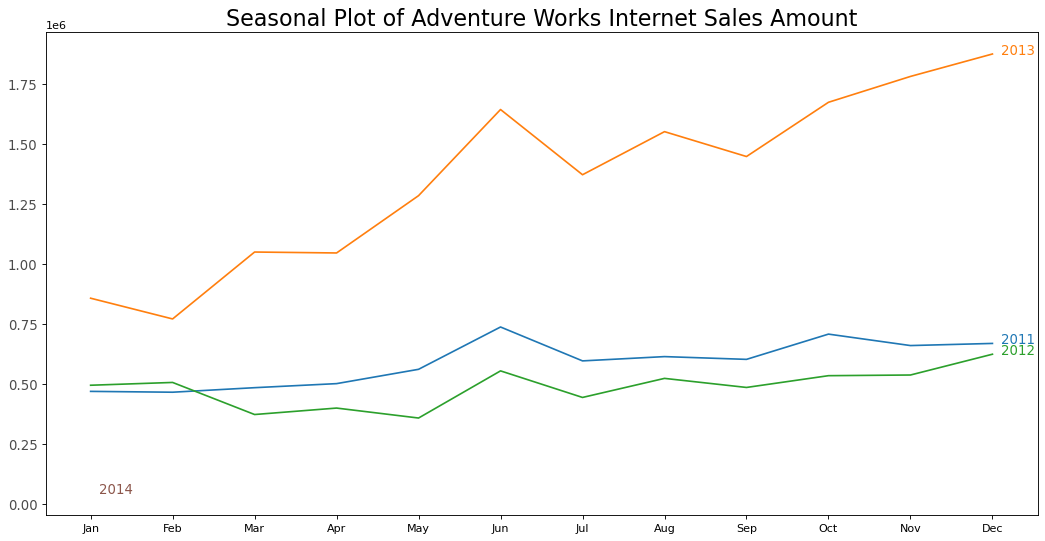

In [101]:
time_series_df['year'] = [d.year for d in time_series_df.index]
time_series_df['month'] = [d.strftime('%b') for d in time_series_df.index]
years = time_series_df['year'].unique()

# Chuẩn bị màu cho biểu đồ
np.random.seed(100)
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive', 'deeppink', 'steelblue', 'firebrick', 'mediumseagreen']

# Vẽ biểu đồ
plt.figure(figsize=(16,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'SalesAmount', data=time_series_df.loc[time_series_df.year==y, :], color=mycolors[i], label=y)
        plt.text(time_series_df.loc[time_series_df.year==y, :].shape[0]-.9, time_series_df.loc[time_series_df.year==y, 'SalesAmount'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.ylabel='Sales Amount'
plt.xlabel='Month'
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Adventure Works Internet Sales Amount", fontsize=20)
plt.show()

Nhận xét:
- Doanh thu tăng mạnh vào giai đoạn giữa và cuối năm.
- Giai đoạn giữa năm có thể là do dịp nghỉ hè của học sinh sinh viên.
- Giai đoạn cuối năm có thể do dịp nghỉ lễ, khách hàng mua quà tặng cho dịp Giáng sinh.